In [1]:
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

In [2]:
with open('tournament_data.json', 'r') as f:
    tournament_data = json.load(f)

memorials = [t for t in tournament_data[::-1] if "memorial" in t[2].lower()]

m_players = [int(t[7]) for t in memorials]
m_rounds = [int(t[6]) for t in memorials]
m_dates = [t[1] for t in memorials]

zapoznawcze = [t for t in tournament_data[::-1] if "entrance" in t[2].lower()]
z_players = ([0] * 4) + [int(z[7]) for z in zapoznawcze]

years = list(map(str, range(2005, 2005 + len(m_players))))

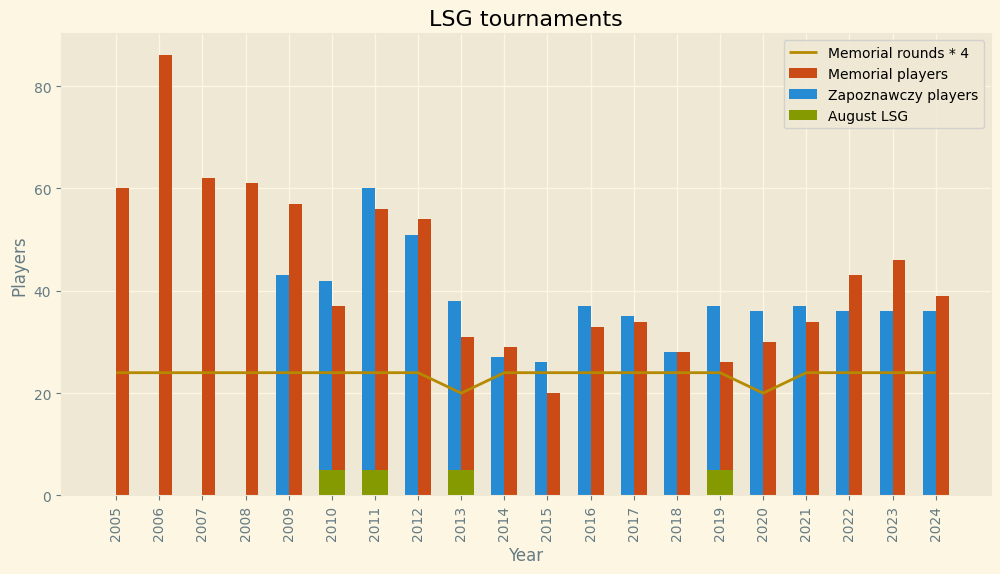

In [3]:
bar_width = 0.3
index = range(len(years))

plt.figure(figsize=(12, 6))
plt.bar([i + bar_width/2 for i in index], m_players, color="#cb4b16", width=bar_width, label="Memorial players")
plt.bar([i - bar_width/2 for i in index], z_players, color="#268bd2", width=bar_width, label="Zapoznawczy players")
plt.plot(years, [rs * 4 for rs in m_rounds], color="#b58900", label="Memorial rounds * 4")
plt.bar(years, [5 if "-08-" in d else 0 for d in m_dates], color="#859900", width=2*bar_width, label="August LSG")
plt.title('LSG tournaments')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Players')
plt.legend()
plt.show()

In [4]:
with open('zarejestrowani.json', 'r') as f:
    zarejestrowani = json.load(f)

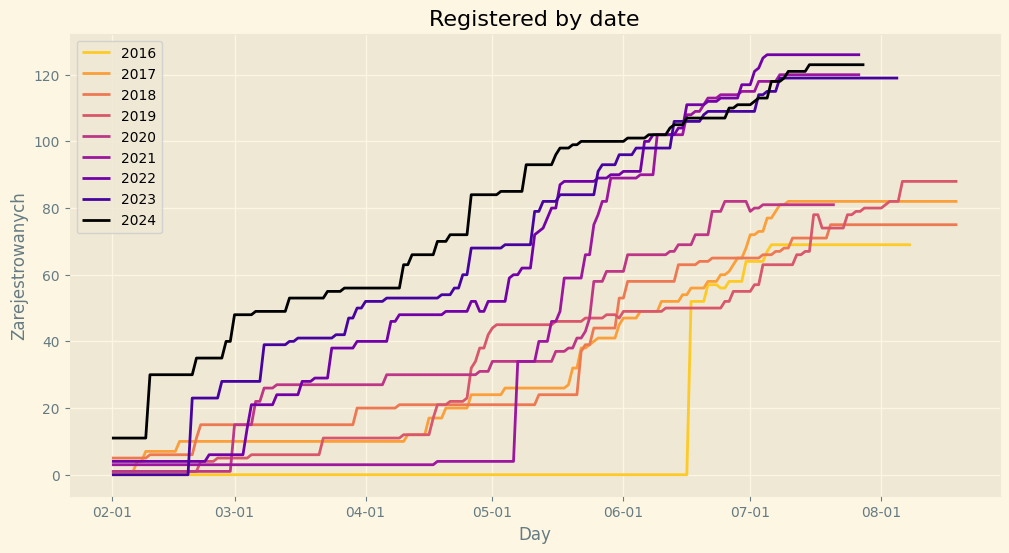

In [5]:
num_years = len(zarejestrowani)
colors = [cm.plasma((x+1) / num_years) for x in reversed(range(num_years-1))]
colors.append((0, 0, 0, 1))

plt.figure(figsize=(12, 6))

for (year, values), color in zip(zarejestrowani.items(), colors):
    dates = list(values.keys())
    counts = list(values.values())
    plt.plot(dates, counts, label=year, color=color)

ticks = []
for month in range(2, 9):
    ticks.append(f"0{month}-01")
plt.xticks(ticks, [date for date in ticks])

plt.xlabel('Day')
plt.ylabel('Zarejestrowanych')
plt.title("Registered by date")
plt.legend()
plt.show()